In [35]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from MixtureMasking import MixtureMasking

In [36]:
class ViolinViolaDataset(Dataset):
    def __init__(self, root_dir, label_map = None, transform=None):
        self.root_dir = root_dir
        self.files = [f for f in os.listdir(root_dir) if f.endswith('.npy')]
        self.label_map = label_map or {'violin': 0, 'viola': 1}
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        filename = self.files[idx]
        filepath = os.path.join(self.root_dir, filename)
        mel = np.load(filepath)
        spec = torch.from_numpy(mel)
        spec = spec.unsqueeze(0)  # Add channel dimension
        label = self.label_map[filename.split('_')[1]] if self.label_map else None
        if self.transform:
            spec = self.transform(spec)
        return spec, label

In [37]:
transform = transforms.Compose([
    transforms.Resize((128, 517)),  # Resize to a fixed size
    transforms.Normalize([0.5], [0.5])  # Normalize the image
])

In [38]:
g_train = torch.Generator()
g_train.manual_seed(17)
train_dataset = ViolinViolaDataset('train/', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

g_testval = torch.Generator().manual_seed(17)
testval_dataset = ViolinViolaDataset('test/', transform=transform)
val_size = int(0.5 * len(testval_dataset))
test_size = len(testval_dataset) - val_size
val_subset, test_subset = random_split(testval_dataset, [val_size, test_size], generator=g_testval)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)

In [39]:
for x, y in train_loader:
    print(x.shape)
    print(y.shape)
    break

torch.Size([32, 1, 128, 517])
torch.Size([32])


In [40]:
class ViolinViolaCNN(nn.Module):
    def __init__(self):
        super(ViolinViolaCNN, self).__init__()

        self.mixturemasking1 = MixtureMasking(freq_param=8, time_param=35, activate_prob=0.6)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=40, stride=(2, 1), kernel_size=(5, 1))   # output: (40, 62, 517)
        self.mixturemasking2 = MixtureMasking(freq_param=4, time_param=35, activate_prob=0.6)
        self.conv2 = nn.Conv2d(in_channels=40, out_channels=32, kernel_size=(3, 2))  # output: (32, 60, 516)
        self.mixturemasking3 = MixtureMasking(freq_param=4, time_param=35, activate_prob=0.6)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=1)  # output: (16, 60, 516)

        self.pool = nn.AdaptiveAvgPool2d((16, 16))  # reduce to fixed-size for Dense

        self.fc1 = nn.Linear(16 * 16 * 16, 64)
        self.fc2 = nn.Linear(64, 16)
        self.fc3 = nn.Linear(16, 12)
        self.out = nn.Linear(12, 2)  # binary classification: violin vs viola

    def forward(self, x, labels):
        x = self.mixturemasking1(x, labels)
        x = F.relu(self.conv1(x))  # -> (40, 62, 517)
        x = self.mixturemasking2(x, labels)
        x = F.relu(self.conv2(x))  # -> (32, 60, 516)
        x = self.mixturemasking3(x, labels)
        x = F.relu(self.conv3(x))  # -> (16, 60, 516)
        x = self.pool(x)           # -> (16, 16, 16)
        x = x.view(x.size(0), -1)  # flatten
        x = F.relu(self.fc1(x))    # -> (64)
        x = F.relu(self.fc2(x))    # -> (16)
        x = F.relu(self.fc3(x))    # -> (12)
        x = self.out(x)            # -> (2)
        return x

In [41]:
class ViolinViolaCrossEntropyLoss(nn.Module):
    def __init__(self):
        super(ViolinViolaCrossEntropyLoss, self).__init__()
        self.register_buffer("class_weights", torch.tensor([1.0, 1.2]))

    def forward(self, outputs, labels):
        if self.class_weights is not None:
            class_weights = self.class_weights.to(outputs.device)
            return F.cross_entropy(outputs, labels, weight=class_weights)
        return F.cross_entropy(outputs, labels)

In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = ViolinViolaCNN()
criterion = ViolinViolaCrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Using device: cuda


In [43]:
from collections import defaultdict

def train(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10):
    max_avg_acc = {}

    model.to(device)

    # Use DataParallel for multiple GPUs
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs with DataParallel")
        model.to(device)  # Move model to CUDA *before* DataParallel
        model = torch.nn.DataParallel(model)
    else:
        model.to(device)


    history = {
        "train_loss": [], "val_loss": [],
        "train_acc": [], "val_acc": [],
        "train_class_acc": [], "val_class_acc": [],
        "train_class_loss": [], "val_class_loss": [],
        "val_roc_y_true": [], "val_roc_y_score": [],
    }

    for epoch in range(num_epochs):
        model.train()
        total_loss, total_correct, total_samples = 0, 0, 0
        class_loss = defaultdict(float)
        class_correct = defaultdict(int)
        class_total = defaultdict(int)

        for X, y in train_loader:
            X, y = X.to(device), y.to(device)

            optimizer.zero_grad()
            logits = model(X, y)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()

            preds = logits.argmax(dim=1)
            total_loss += loss.item() * y.size(0)
            total_correct += (preds == y).sum().item()
            total_samples += y.size(0)

            for cls in [0, 1]:  # violin, viola
                idx = (y == cls)
                if idx.sum().item() > 0:
                    cls_loss = criterion(logits[idx], y[idx])
                    class_loss[cls] += cls_loss.item() * idx.sum().item()
                    class_correct[cls] += (preds[idx] == y[idx]).sum().item()
                    class_total[cls] += idx.sum().item()

        train_loss = total_loss / total_samples
        train_acc = total_correct / total_samples
        train_class_acc = [class_correct[c] / class_total[c] for c in [0, 1]]
        train_class_loss = [class_loss[c] / class_total[c] for c in [0, 1]]

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["train_class_acc"].append(train_class_acc)
        history["train_class_loss"].append(train_class_loss)

        # --- Validation ---
        model.eval()
        total_loss, total_correct, total_samples = 0, 0, 0
        class_loss = defaultdict(float)
        class_correct = defaultdict(int)
        class_total = defaultdict(int)
        val_y_true, val_y_score = [], []

        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                logits = model(X, None)
                loss = criterion(logits, y)

                preds = logits.argmax(dim=1)
                probs = torch.softmax(logits, dim=1)[:, 1]

                total_loss += loss.item() * y.size(0)
                total_correct += (preds == y).sum().item()
                total_samples += y.size(0)

                val_y_true.extend(y.cpu().numpy())
                val_y_score.extend(probs.cpu().numpy())

                for cls in [0, 1]:
                    idx = (y == cls)
                    if idx.sum().item() > 0:
                        cls_loss = criterion(logits[idx], y[idx])
                        class_loss[cls] += cls_loss.item() * idx.sum().item()
                        class_correct[cls] += (preds[idx] == y[idx]).sum().item()
                        class_total[cls] += idx.sum().item()

        val_loss = total_loss / total_samples
        val_acc = total_correct / total_samples
        val_class_acc = [class_correct[c] / class_total[c] for c in [0, 1]]
        val_class_loss = [class_loss[c] / class_total[c] for c in [0, 1]]

        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        history["val_class_acc"].append(val_class_acc)
        history["val_class_loss"].append(val_class_loss)
        history["val_roc_y_true"] = val_y_true
        history["val_roc_y_score"] = val_y_score

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"  Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f} | Violin Acc: {train_class_acc[0]:.4f} | Viola Acc: {train_class_acc[1]:.4f}")
        print(f"  Val   Loss: {val_loss:.4f} | Acc: {val_acc:.4f} | Violin Acc: {val_class_acc[0]:.4f} | Viola Acc: {val_class_acc[1]:.4f}")

        # Save model every epoch
        torch.save(model.state_dict(), f"violin_viola_cnn_mixturemasking_epoch_{epoch+1}.pth")
        print(f"Model saved as violin_viola_cnn_mixturemasking_epoch_{epoch+1}.pth")
        # Save maximum average accuracy between violin and viola
        max_avg_acc[(epoch + 1)] = (train_acc + val_acc) / 2

    return history, max_avg_acc

def plot_history(history):
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss over Epochs")

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["train_acc"], label="Train Acc")
    plt.plot(epochs, history["val_acc"], label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Accuracy over Epochs")

    plt.tight_layout()
    plt.show()

def plot_roc(y_true, y_score):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (Violin vs Viola)")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

Using 2 GPUs with DataParallel
Epoch 1/50
  Train Loss: 0.3744 | Acc: 0.8157 | Violin Acc: 0.8555 | Viola Acc: 0.7540
  Val   Loss: 0.2554 | Acc: 0.8867 | Violin Acc: 0.8872 | Viola Acc: 0.8854
Model saved as violin_viola_cnn_mixturemasking_epoch_1.pth
Epoch 2/50
  Train Loss: 0.1530 | Acc: 0.9387 | Violin Acc: 0.9413 | Viola Acc: 0.9347
  Val   Loss: 0.1990 | Acc: 0.9120 | Violin Acc: 0.9022 | Viola Acc: 0.9327
Model saved as violin_viola_cnn_mixturemasking_epoch_2.pth
Epoch 3/50
  Train Loss: 0.1209 | Acc: 0.9540 | Violin Acc: 0.9588 | Viola Acc: 0.9467
  Val   Loss: 0.2521 | Acc: 0.9140 | Violin Acc: 0.9780 | Viola Acc: 0.7786
Model saved as violin_viola_cnn_mixturemasking_epoch_3.pth
Epoch 4/50
  Train Loss: 0.1023 | Acc: 0.9600 | Violin Acc: 0.9650 | Viola Acc: 0.9523
  Val   Loss: 0.2866 | Acc: 0.9008 | Violin Acc: 0.9799 | Viola Acc: 0.7337
Model saved as violin_viola_cnn_mixturemasking_epoch_4.pth
Epoch 5/50
  Train Loss: 0.0874 | Acc: 0.9658 | Violin Acc: 0.9707 | Viola Acc: 0

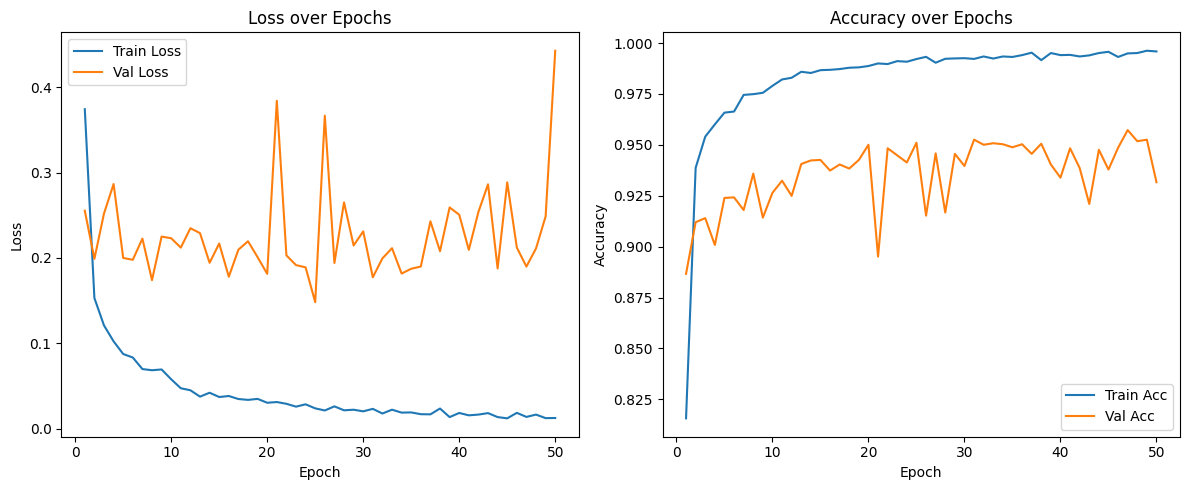

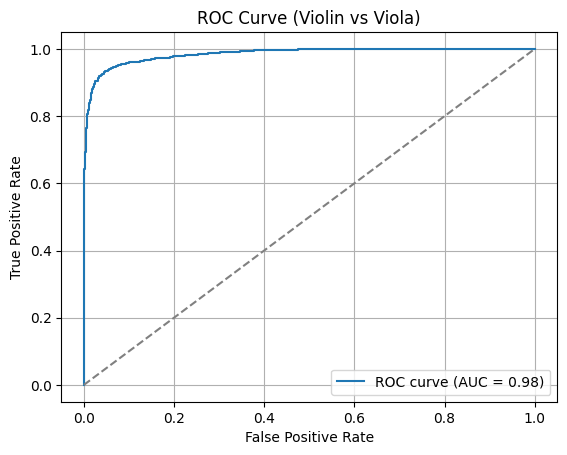

Best model restored from epoch 47 with max average accuracy 0.9761


In [44]:
history, max_avg_acc = train(model, train_loader, val_loader, criterion, optimizer, device='cuda', num_epochs=50)

plot_history(history)
plot_roc(history["val_roc_y_true"], history["val_roc_y_score"])

# Restore the best model based on maximum average accuracy
best_epoch = max(max_avg_acc, key=max_avg_acc.get)
state_dict = torch.load(f"violin_viola_cnn_mixturemasking_epoch_{best_epoch}.pth")
# Remove 'module.' prefix from all keys
new_state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}
model.load_state_dict(new_state_dict)
print(f"Best model restored from epoch {best_epoch} with max average accuracy {max_avg_acc[best_epoch]:.4f}")

In [45]:
from sklearn.metrics import f1_score, precision_score, recall_score

for epoch in range(1, 51):
    state_dict = torch.load(f"violin_viola_cnn_mixturemasking_epoch_{epoch}.pth")
    new_state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}
    model.load_state_dict(new_state_dict)
    model.to('cpu')
    model.eval()
    total_correct, total_samples = 0, 0
    class_correct = defaultdict(int)
    class_total = defaultdict(int)

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to('cpu'), y.to('cpu')
            logits = model(X, None)
            preds = logits.argmax(dim=1)
            total_correct += (preds == y).sum().item()
            total_samples += y.size(0)

            # For accuracy
            for i in range(y.size(0)):
                class_total[y[i].item()] += 1
                class_correct[y[i].item()] += (preds[i] == y[i]).item()

            # For F1/Precision/Recall
            all_preds.extend(preds.tolist())
            all_labels.extend(y.tolist())

    test_acc = total_correct / total_samples
    print(f"Epoch {epoch}: Test Accuracy: {test_acc:.4f}")

    for cls in [0, 1]:
        if class_total[cls] > 0:
            class_acc = class_correct[cls] / class_total[cls]
            print(f"  Class {cls} Accuracy: {class_acc:.4f}")

    avg_class_acc = sum(class_correct[c] / class_total[c] for c in [0, 1]) / 2
    print(f"Average Class Accuracy: {avg_class_acc:.4f}")

    # F1, Precision, Recall (macro = average across classes)
    f1 = f1_score(all_labels, all_preds, average='macro')
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    print(f"F1 Score (macro): {f1:.4f}")
    print(f"Precision (macro): {precision:.4f}")
    print(f"Recall (macro): {recall:.4f}")
    print("-" * 40)

Epoch 1: Test Accuracy: 0.8775
  Class 0 Accuracy: 0.8717
  Class 1 Accuracy: 0.8893
Average Class Accuracy: 0.8805
F1 Score (macro): 0.8662
Precision (macro): 0.8573
Recall (macro): 0.8805
----------------------------------------
Epoch 2: Test Accuracy: 0.9108
  Class 0 Accuracy: 0.8924
  Class 1 Accuracy: 0.9480
Average Class Accuracy: 0.9202
F1 Score (macro): 0.9029
Precision (macro): 0.8925
Recall (macro): 0.9202
----------------------------------------
Epoch 3: Test Accuracy: 0.9113
  Class 0 Accuracy: 0.9714
  Class 1 Accuracy: 0.7892
Average Class Accuracy: 0.8803
F1 Score (macro): 0.8953
Precision (macro): 0.9175
Recall (macro): 0.8803
----------------------------------------
Epoch 4: Test Accuracy: 0.8976
  Class 0 Accuracy: 0.9729
  Class 1 Accuracy: 0.7447
Average Class Accuracy: 0.8588
F1 Score (macro): 0.8774
Precision (macro): 0.9084
Recall (macro): 0.8588
----------------------------------------
Epoch 5: Test Accuracy: 0.9257
  Class 0 Accuracy: 0.9206
  Class 1 Accuracy

In [46]:
# Best choice: Epoch 47